In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install deepinv
!pip install odl

In [3]:
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from skimage import data
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
import json
import deepinv as dinv
from skimage.transform import iradon
from torch.utils.data import Dataset, DataLoader
from torch import Tensor
from itertools import repeat
import odl
from odl.phantom import ellipsoid_phantom
from odl import uniform_discr


In [4]:
from typing import Tuple, Union, Iterator
from itertools import repeat

class EllipsesDataset(torch.utils.data.Dataset):
    def __init__(self, shape=(256,256), length=5000, fixed_seed=42, fold="train"):
        self.shape = shape
        self.length = length
        self.max_n_ellipse = 70
        self.rng = np.random.RandomState(fixed_seed + (1 if fold=="validation" else 0))
        self._precompute_ellipses()
        self.space = odl.uniform_discr([-shape[0]/2, -shape[1]/2],
                                       [shape[0]/2,  shape[1]/2],
                                       shape)
    def _precompute_ellipses(self):
        self.ellipses_data = []
        for _ in range(self.length):
            v  = self.rng.uniform(-0.4, 1.0, self.max_n_ellipse)
            a1 = 0.2 * self.rng.exponential(1.0, self.max_n_ellipse)
            a2 = 0.2 * self.rng.exponential(1.0, self.max_n_ellipse)
            x  = self.rng.uniform(-0.9, 0.9, self.max_n_ellipse)
            y  = self.rng.uniform(-0.9, 0.9, self.max_n_ellipse)
            rot= self.rng.uniform(0, 2*np.pi, self.max_n_ellipse)
            n_ell = min(self.rng.poisson(self.max_n_ellipse), self.max_n_ellipse)
            v[n_ell:] = 0
            self.ellipses_data.append(np.stack([v, a1, a2, x, y, rot], axis=1))
    def __len__(self):
        return self.length
    def __getitem__(self, idx):
        ell = self.ellipses_data[idx]
        img_odl = ellipsoid_phantom(self.space, ell)      # ODL space element
        arr = img_odl.asarray()                           # now a NumPy array, shape (H,W)
        # normalize foreground to [0,1]
        mask = (arr != 0)
        if mask.any():
            arr[mask] = (arr[mask] - arr[mask].min()) / (arr[mask].max() - arr[mask].min())
        else:
            arr[:] = 0.0
        return torch.from_numpy(arr[None]).float()        # [1,H,W]


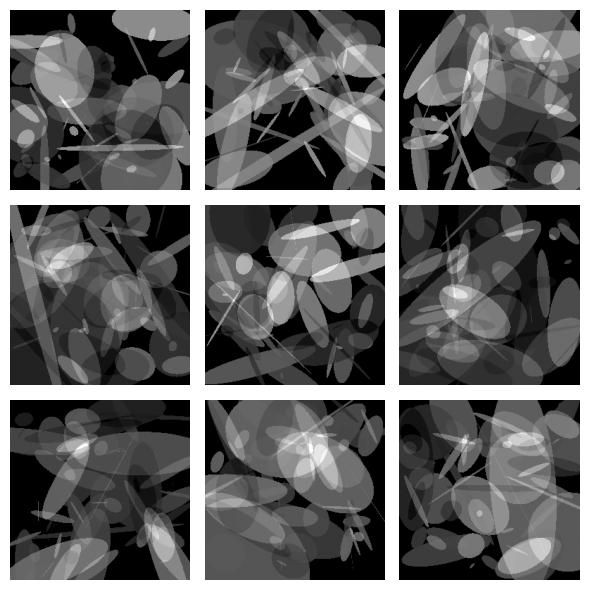

In [5]:
ds = EllipsesDataset(shape=(256,256), length=16, fixed_seed=42, fold="train")

# 2) Grab the first N images
imgs = []
for i in range(9):
    img = ds[i]             # this is a torch tensor [1,H,W]
    imgs.append(img.squeeze(0).numpy())

# 3) Plot them in a 3×3 grid
fig, axs = plt.subplots(3, 3, figsize=(6,6))
for ax, im in zip(axs.flat, imgs):
    ax.imshow(im, cmap="gray", vmin=0, vmax=1)
    ax.axis("off")
plt.tight_layout()
plt.show()

In [6]:
# Import UNet file
sys.path.append('/content/drive/MyDrive/MScProject')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from Model_arch import UNet


# Import Elipses Data
train_ds = EllipsesDataset(shape=(256,256), length=5000, fixed_seed=42, fold="train")
test_ds  = EllipsesDataset(shape=(256,256), length=1000, fixed_seed=42, fold="validation")

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=64)

In [7]:
class OperatorFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, operator, x):
        # ctx.operator saved for backward
        ctx.operator = operator
        # call the DeepInv forward operator A
        with torch.no_grad():
            out = operator.A(x)
        # no need to save x unless A is nonlinear
        return out

    @staticmethod
    def backward(ctx, grad_output):
        # in the backward pass, apply the adjoint A_adjoint
        operator = ctx.operator
        grad_input = operator.A_adjoint(grad_output)
        # first returned None says “no gradient for operator”
        return None, grad_input

class OperatorModule(torch.nn.Module):
    def __init__(self, operator):
        super().__init__()
        self.operator = operator

    def forward(self, x):
        # call our custom Function
        return OperatorFunction.apply(self.operator, x)

    def A_dagger(self, y):
        # if you ever want to call the adjoint directly
        return self.operator.A_adjoint(y)

In [8]:
angles_torch = torch.linspace(0,180,60,device=device)

angles_torch = torch.linspace(0,180,60,device=device)
physics_raw = dinv.physics.Tomography(
    img_width=256, angles=angles_torch, device=device,
    noise_model=dinv.physics.GaussianNoise(sigma=0.02)
)

physics = OperatorModule(physics_raw)

In [9]:
pre_model = UNet(1, 1)
pre_model = pre_model.to(device)
opt = torch.optim.Adam(pre_model.parameters(), lr = 1e-4)

In [10]:
epochs = 10
loss_fn = torch.nn.MSELoss()

for epoch in range(epochs):
    pre_model.train()
    running = 0.0
    for x_true in train_loader:              # now x_true is [B,1,256,256]
      x_true = x_true.to(device)
      y = physics(x_true)             # forward project → [B,1,det,angles]
      x0 = physics.A_dagger(y)         # back-project → [B,1,256,256]
      y_pred = pre_model(x0)               # refine in image space
      loss   = loss_fn(y_pred, x_true)
      loss.backward()
      opt.step()
      opt.zero_grad()
      running += loss.item()
    print(f"Epoch {epoch:02d} train MSE: {running/len(train_loader):.4f}")

    pre_model.eval()
    pre_model.train()
    running_test = 0.0
    with torch.no_grad():
      for x_true in test_loader:              # now x_true is [B,1,256,256]
        x_true = x_true.to(device)
        y = physics(x_true)             # forward project → [B,1,det,angles]
        x0 = physics.A_dagger(y)         # back-project → [B,1,256,256]
        y_pred = pre_model(x0)               # refine in image space
        loss   = loss_fn(y_pred, x_true)
        running_test += loss.item()
    print(f"Epoch {epoch:02d} test  MSE: {running_test/len(test_loader):.4f}")


Epoch 00 train MSE: 147.0545
Epoch 00 test  MSE: 15.4663
Epoch 01 train MSE: 4.7716
Epoch 01 test  MSE: 0.5332
Epoch 02 train MSE: 0.3919
Epoch 02 test  MSE: 0.3198
Epoch 03 train MSE: 0.2856
Epoch 03 test  MSE: 0.2546
Epoch 04 train MSE: 0.2341
Epoch 04 test  MSE: 0.2361
Epoch 05 train MSE: 0.2049
Epoch 05 test  MSE: 0.1846
Epoch 06 train MSE: 0.1718
Epoch 06 test  MSE: 0.1567
Epoch 07 train MSE: 0.1593
Epoch 07 test  MSE: 0.1366
Epoch 08 train MSE: 0.1456
Epoch 08 test  MSE: 0.1229
Epoch 09 train MSE: 0.2033
Epoch 09 test  MSE: 0.1316


In [11]:
# Save Weights

os.makedirs('/content/drive/MyDrive/MScProject/checkpoints', exist_ok=True)
torch.save(pre_model.state_dict(), '/content/drive/MyDrive/MScProject/checkpoints/pre_model.pth')


In [14]:
from google.colab import files
print("Download pre_model.pth")
files.download("/content/drive/MyDrive/MScProject/checkpoints/pre_model.pth")

Download pre_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>